In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc3 as pm

# Mixture Models

$$
f(x|w, \theta) = \sum_{i=1}^{n}w_if_i(x|\theta_i)
$$

$$
f(x|w, \mu, \sigma) = \sum_{i=1}^{n}w_i \mathcal{N}(x|\mu_i, \sigma_i)
$$

In [2]:
N = 1000

w_trues = np.array([0.25, 0.55, .20])
mu_trues = np.array([1., 3., 7.])
sigma_trues = np.array([.3, 1., .5])

In [3]:
components = np.random.choice(mu_trues.size, size=N, p=w_trues)
data = np.random.normal(mu_trues[components], sigma_trues[components], size=N)

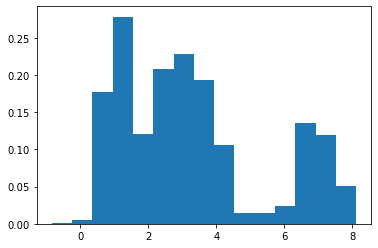

In [4]:
plt.hist(data, bins=15, density=True, lw=0);


$$
\mathrm{Dir}(\mathbf{x}|\mathbf{\alpha}) = \frac{1}{\mathrm{B}(\mathbf{\alpha})}\prod_{i=1}^K x_i ^ {\alpha_i-1}
$$

In [5]:
## visualization routines from http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
import matplotlib.tri as tri
from functools import reduce

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
    
# Mid-points of triangle sides opposite of each corner
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                     reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.text(-.1, 0, r'$w_1$', fontsize=14)
    plt.text(1.1, 0, r'$w_2$', horizontalalignment='right', fontsize=14)
    plt.text(0.5, .9, r'$w_3$', fontsize=14)
    plt.axis('off')

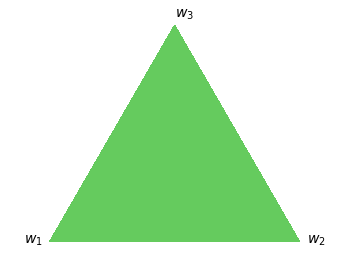

In [6]:
alpha = [1., 1., 1., ]
draw_pdf_contours(Dirichlet(alpha))

In [7]:
model = pm.Model()

k = 4

with model:
    # weights
    w = pm.Dirichlet('w', a=np.ones(k), shape=k, testval=[.3, .3, .3, .3])
    
    means = pm.Uniform('means', data.min(), data.max(), shape=k, testval=[2, 3, 4, 6])
    sd = pm.HalfNormal('sd', sd=data.max() - data.min(), shape=k)
    
    if k > 1:
        switches = [pm.math.switch(means[c] - means[c-1] < 0, -np.inf, 0) for c in range(1, k)]
        order_means_potential = pm.Potential('order_means_potential', pm.math.sum(switches))
        
    category = pm.Categorical('category', p=w, shape=len(data))
    
    points = pm.Normal('obs', mu=means[category], sd=sd[category], observed=data)

In [ ]:
with model:
    trace = pm.sample(2000, tune=5000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sd, means, w]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains, 0 divergences:   2%|▏         | 296/14000 [01:06<47:16,  4.83draws/s]  

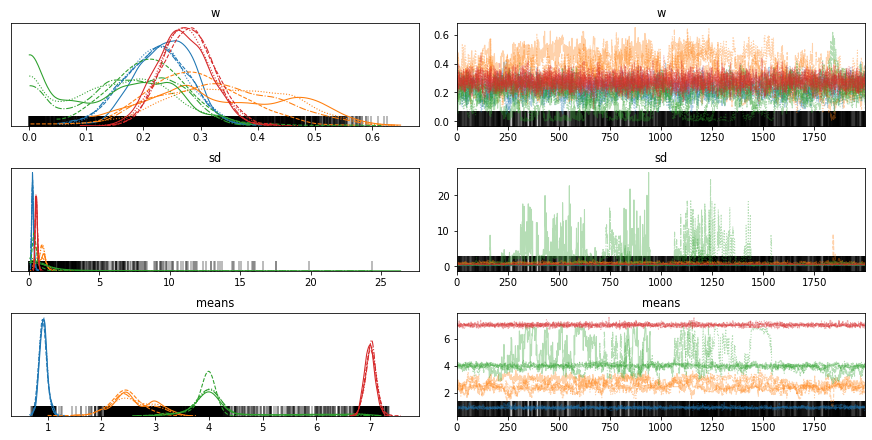

In [67]:
pm.traceplot(trace, ['w', 'sd', 'means']);

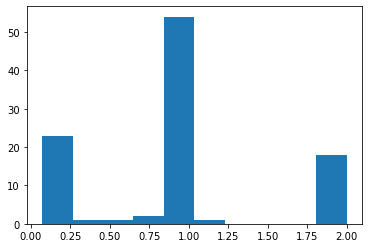

In [34]:
plt.hist(trace['category'].mean(axis=0));

# Marginalized Gaussian Mixture Model

In [9]:
model = pm.Model()

k = 4

with model:
    # subpopulation weights
    w = pm.Dirichlet('w', a=np.ones(k), shape=k, testval=[.3, .3, .3, .1])

    # subpopulation means
    means = pm.Uniform('means', data.min(), data.max(), shape=k, testval=[1, 3, 5, 6])

    # subpopulation standard deviations
    sd = pm.HalfNormal('sd', sd=data.max()-data.min(), shape=k)
    
    # avoid the exchange symmetry to make sampling easier
    if k > 1:
        switchs = [pm.math.switch(means[c]-means[c-1] < 0, -np.inf, 0) for c in range(1, k)]
        order_means_potential = pm.Potential('order_means_potential', pm.math.sum(switchs))
 
    mixture = pm.NormalMixture('obs', w, mu=means, sd=sd, observed=data)

In [10]:
with model:
    start = pm.find_MAP()
    trace = pm.sample(5000, start=start)

logp = -193.72, ||grad|| = 0.34242: 100%|██████████| 51/51 [00:00<00:00, 1741.34it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, w]
Sampling 4 chains, 12,254 divergences: 100%|██████████| 22000/22000 [00:56<00:00, 386.76draws/s]
There were 3126 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6877535639947824, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2842 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3025 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8887874989328106, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3258 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of eff

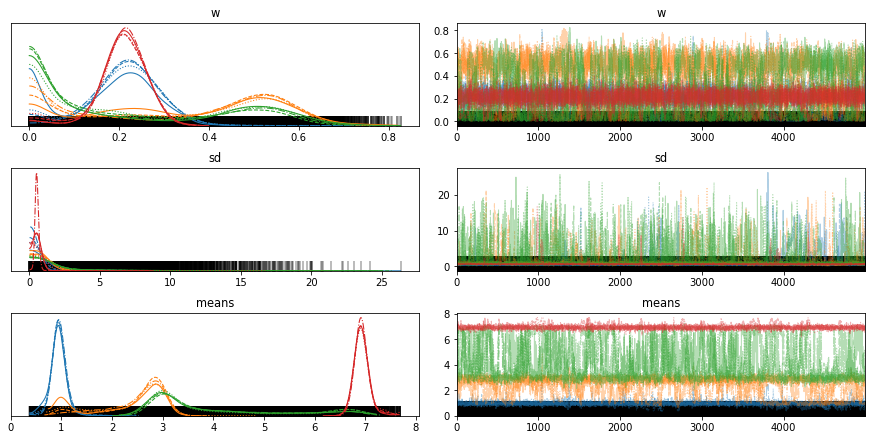

In [11]:
pm.traceplot(trace, ['w', 'sd', 'means']);